# Optimizing windows for satellite data 
### Brian Mapes Nov 20222

In this tutorial we read the pair of images using `imread`, compare them visually 
and process using OpenPIV. Here the import is using directly the basic functions and methods

In [1]:
from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio

In [2]:
# import pyprocess # My version in local directory

In [24]:
frame_a  = tools.imread( 'DATA/image_0_2022_09_06_15_15_00Z.png' ) #[:,-1024:] # Make square 1024x1024
frame_b  = tools.imread( 'DATA/image_1_2022_09_06_15_45_00Z.png' ) #[:,-1024:]

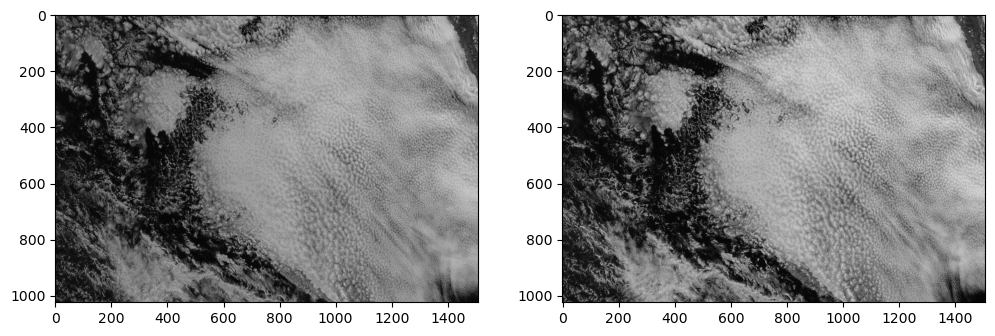

In [42]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [83]:
winsize = 48 # pixels, interrogation window size in frame A
searchsize = 48  # pixels, search in image B big enough to contain credible velocity 
overlap = 24 # pixels, 50% overlap if half of winsize
dt = 1 # time interval between images, converts pixel displacement to velocity

# Coordinates of velocity positions in image array
x, y = pyprocess.get_coordinates(image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

In [84]:
u, v, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2mean')
# return u/dt, v/dt, sig2noise

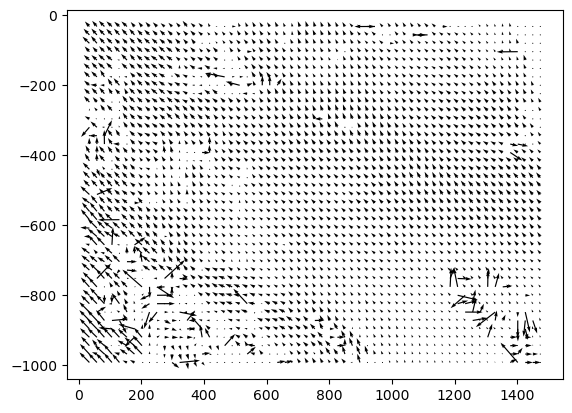

In [85]:
plt.quiver(x,-y, u,-v)

In [86]:
# Two passes of outlier removal 
u, v, mask = validation.global_std(u, v, std_threshold=3)
u, v, mask = validation.global_std(u, v, std_threshold=3)

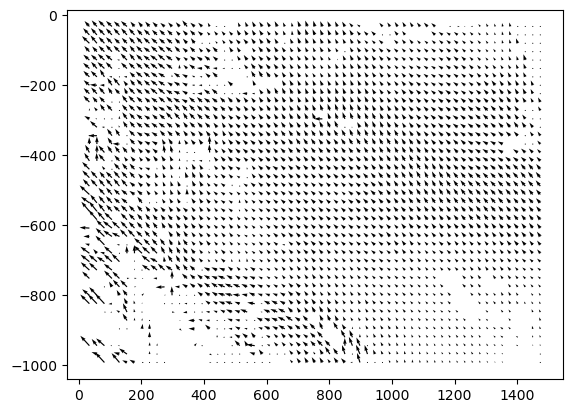

In [87]:
plt.quiver(x,-y, u,-v)

In [88]:
# Fill gaps a bit, once or twice
u, v = filters.replace_outliers( u, v, 
                                  method='localmean', 
                                  max_iter=7, 
                                  kernel_size=7)

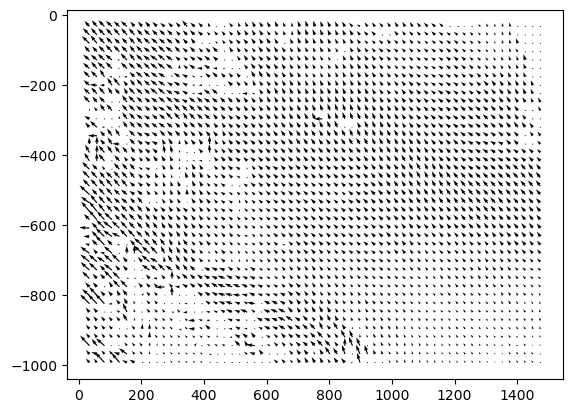

In [89]:
plt.quiver(x,-y, u,-v)

In [90]:
#save in the simple ASCII table format
# image coords to xy coords: 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u, v = tools.transform_coordinates(x, y, u, v)

tools.save(x, y, u, v, mask, 'exp1_001.txt' )

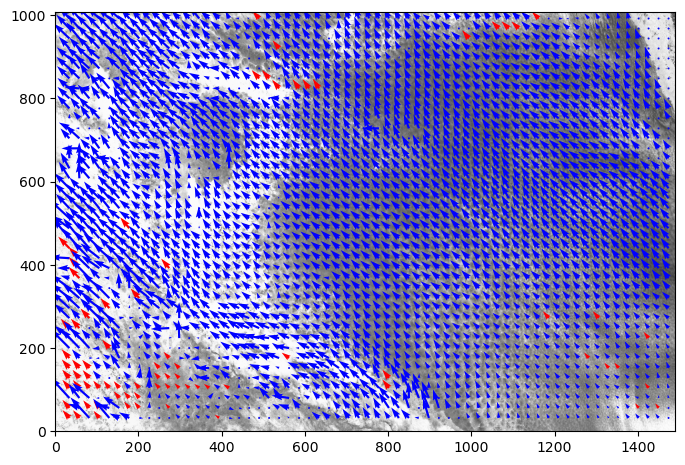

In [111]:
# Display from that file 
fig, ax = plt.subplots(figsize=(8,10))
tools.display_vector_field('exp1_001.txt', 
                           ax=ax, 
                           scale=300, # scale defines here the arrow length, but inversely
                           width=0.0035, # width is the thickness of the arrow
                           on_img=True, # overlay on the first image
                           image_name='DATA/image_0_2022_09_06_15_15_00Z.png');

In [92]:
#from IPython.display import Video
#Video("DATA/closedcellday_2022_09_06.mp4", embed=True)

# Open in browser: 
# file:///Users/brianmapes/Github/stratocu_waves/DATA/closedcellday_2022_09_06.mp4

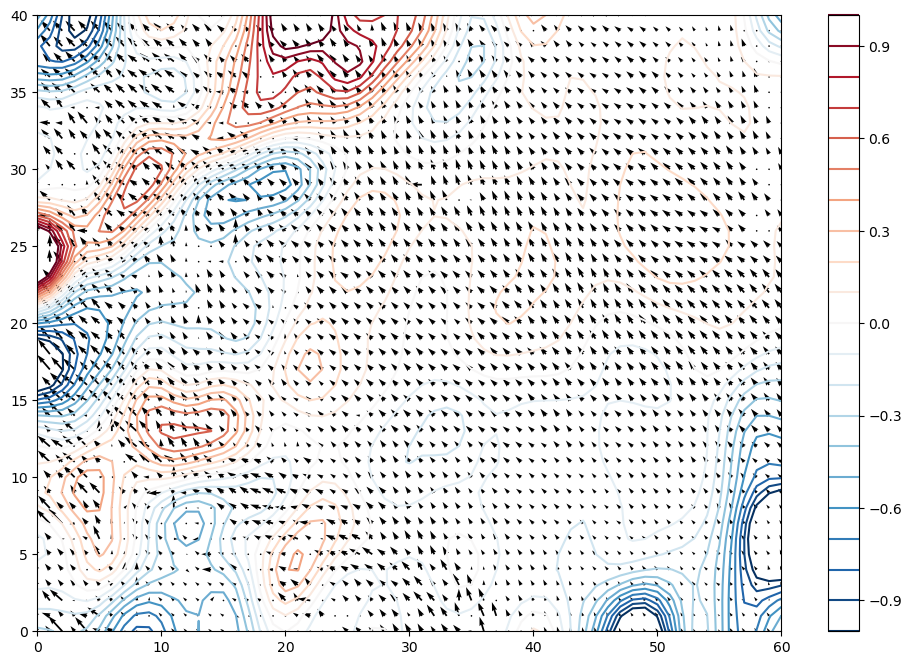

In [139]:
# Divergence du/dx + dv/dy
from scipy.ndimage import gaussian_filter as smoo

div = np.gradient(u)[0] +np.gradient(v)[1] # doesn't look right 

fig,ax = plt.subplots(figsize=(12,8))
from scipy.ndimage import gaussian_filter as smoo
plt.contour(smoo(div, 2), cmap='RdBu_r', levels= (-10+np.arange(21))/10.); plt.colorbar()
plt.quiver( (x-x.min()) /winsize*2, (y-y.min()) /winsize*2, u,v)

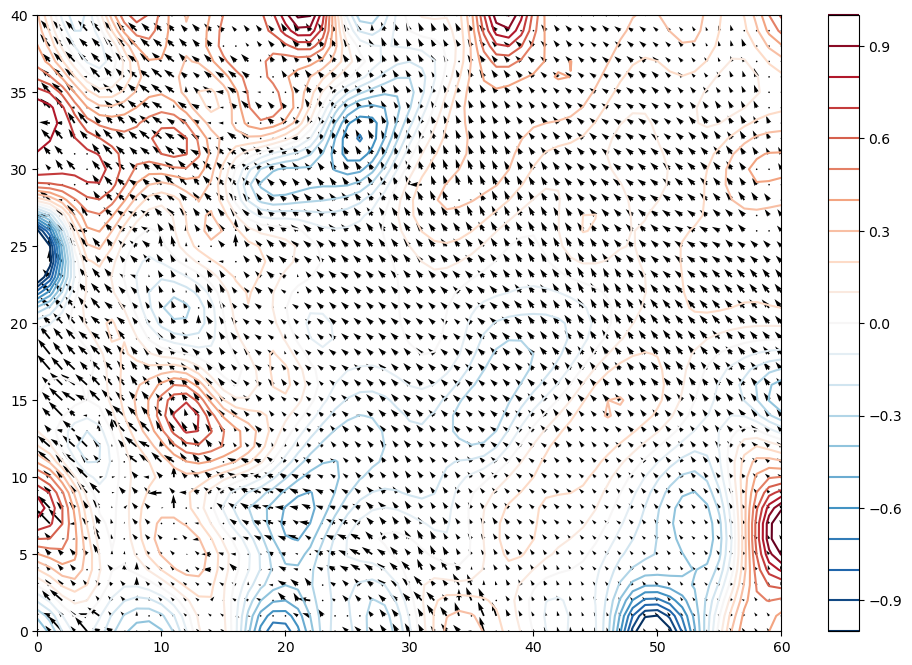

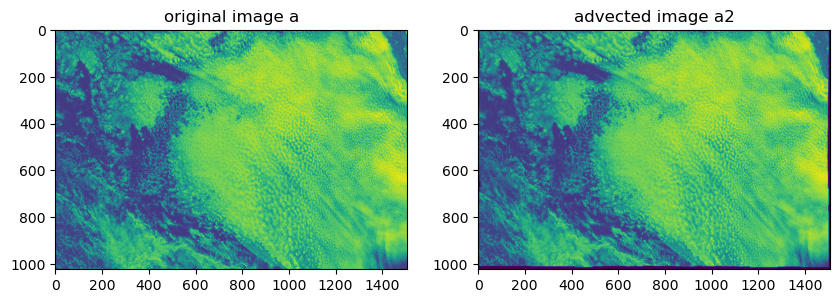

In [292]:
# A loop, god help me, inelegant but it's clear. Build a2 as an average 

# sum/num will be the average, just remember to avoid zero division
a2sum = frame_a.copy()*0.0
a2num = frame_a.copy()*0

# u and v offsets in nearest pixel, integer
xi = x.round().astype(int).ravel()
yi = y.round().astype(int).ravel()
ui = u.round().astype(int).ravel()
vi = v.round().astype(int).ravel()


# Loop over all the little windows in a and add them into a2 
for idx,vpoint in enumerate(xi.ravel()):
    windowa = (slice(yi[idx]-winsize//2, yi[idx]+winsize//2,1), 
               slice(xi[idx]-winsize//2, xi[idx]+winsize//2,1) ) # source image

    windowa2= (slice(yi[idx]-winsize//2 + -vi[idx], 
                     yi[idx]+winsize//2 + -vi[idx],1), 
               slice(xi[idx]-winsize//2 + ui[idx], 
                     xi[idx]+winsize//2 + ui[idx],1) ) # where to put it
    
    try: 
        a2sum[windowa2] += frame_a[windowa]
        a2num[windowa2] += 1
    except: 
        continue
        
a2 = (a2sum/(a2num 
             +0.000001)) # avoid division by zero

plt.figure(figsize=[10,5])
plt.subplot(1, 2, 1)
plt.imshow(frame_a); plt.title('original image a'); plt.clim(0,200)
plt.subplot(1, 2, 2)
plt.imshow(a2); plt.title('advected image a2'); plt.clim(0,200)

In [259]:
idx

2500

In [260]:
windowa2

(slice(8, 56, 1), slice(1450, 1498, 1))

In [261]:
window

(slice(203, 400, 1), slice(403, 700, 1))

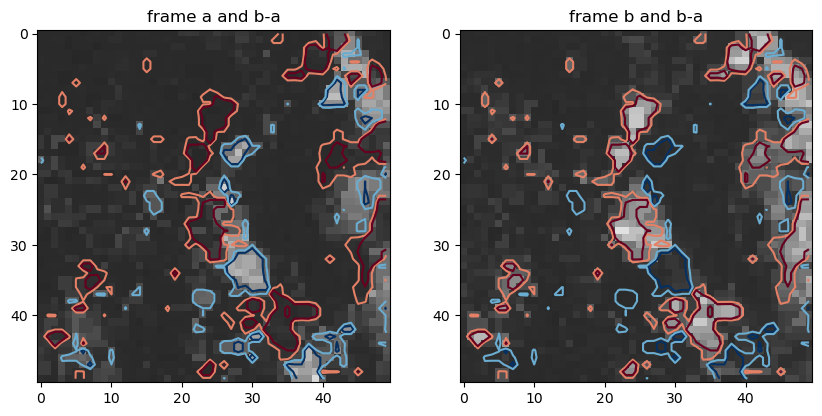

In [294]:
# Difference is mostly advection (+/- downwind dipoles)

box = (slice(500,550,1), slice(350,400,1) )

plt.figure(figsize=[10,5])

plt.subplot(1, 2, 1)
plt.imshow(frame_a[box],cmap=plt.cm.gray); plt.title('frame a and b-a'); plt.clim(0,200)
plt.contour((frame_b-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')

plt.subplot(1, 2, 2)
plt.imshow(frame_b[box],cmap=plt.cm.gray); plt.title('frame b and b-a'); plt.clim(0,200)
plt.contour((frame_b-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')

# plt.colorbar()

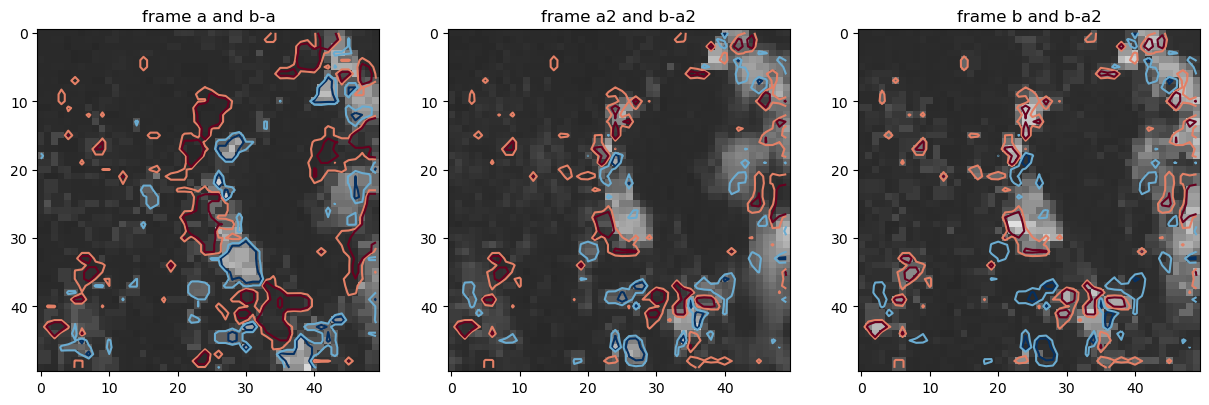

In [293]:
box = (slice(500,550,1), slice(350,400,1) )

plt.figure(figsize=[15,5])

plt.subplot(1, 3, 1)
plt.imshow(frame_a[box],cmap=plt.cm.gray); plt.title('frame a and b-a'); plt.clim(0,200)
#plt.contour((a2-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')
plt.contour((frame_b-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')

plt.subplot(1, 3, 2)
plt.imshow(a2[box],cmap=plt.cm.gray); plt.title('frame a2 and b-a2'); plt.clim(0,200)
plt.contour((frame_b-a2)[box],levels=[-50,-25,25,50], cmap='RdBu_r')
#plt.contour((frame_b-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')

plt.subplot(1, 3, 3)
plt.imshow(frame_b[box],cmap=plt.cm.gray); plt.title('frame b and b-a2'); plt.clim(0,200)
plt.contour((frame_b-a2)[box],levels=[-50,-25,25,50], cmap='RdBu_r')
#plt.contour((frame_b-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')

# plt.colorbar()

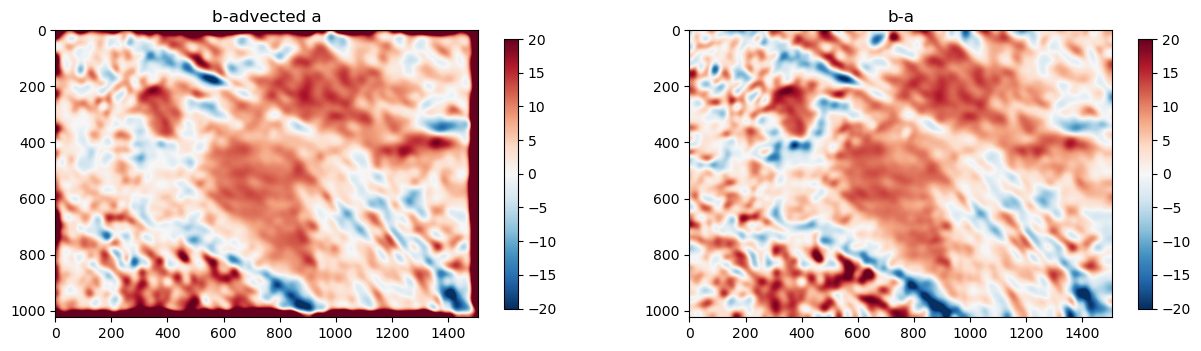

In [291]:
# waves 
plt.figure(figsize=[15,5])

plt.subplot(1, 2, 1)
plt.imshow(smoo(frame_b-a2, 13), cmap='RdBu_r')
plt.clim(-20,20)
plt.title('b-advected a')
plt.colorbar(shrink=0.7)

plt.subplot(1, 2, 2)
plt.imshow(smoo(frame_b-frame_a, 13), cmap='RdBu_r')
plt.clim(-20,20)
plt.title('b-a')
plt.colorbar(shrink=0.7)